In [1]:
# ------------------------------------------define logging and working directory
from ProjectRoot import change_wd_to_project_root
change_wd_to_project_root()
from src.utils.Tensorflow_helper import choose_gpu_by_id
# ------------------------------------------define GPU id/s to use
GPU_IDS = '0,1'
GPUS = choose_gpu_by_id(GPU_IDS)
print(GPUS)
# ------------------------------------------jupyter magic config
%matplotlib inline
%reload_ext autoreload
%autoreload 2
# ------------------------------------------ import helpers
# this should import glob, os, and many other standard libs
from src.utils.Notebook_imports import *
from tensorflow.python.client import device_lib
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
# local imports
from src.utils.Utils_io import Console_and_file_logger, init_config
from src.visualization.Visualize import show_2D_or_3D
from src.utils.KerasCallbacks import get_callbacks

# import external libs
import cv2
import pandas as pd

EXPERIMENT = 'temp/PhaseRegression_tests'
timestemp = str(datetime.datetime.now().strftime("%Y-%m-%d_%H_%M")) # ad a timestep to each project to make repeated experiments unique

MODEL_PATH = os.path.join('models', EXPERIMENT, timestemp)
TENSORBOARD_LOG_DIR = os.path.join('reports/tensorboard_logs', EXPERIMENT,timestemp)
CONFIG_PATH = os.path.join('reports/configs/',EXPERIMENT,timestemp)
HISTORY_PATH = os.path.join('reports/history/',EXPERIMENT,timestemp)

# General params
SEED = 42 # define a seed for the generator shuffle
BATCHSIZE = 4 # 32, 64, 24, 16, 1 for 3D use: 4
GENERATOR_WORKER = BATCHSIZE # if not set, use batchsize

DIM = [8, 64, 64] # network input params for spacing of 3, (z,y,x)
T_SHAPE = 36
SPACING = [10, 3, 3] # if resample, resample to this spacing, (z,y,x)

# Model params
DEPTH = 3 # depth of the encoder
FILTERS = 32 # initial number of filters, will be doubled after each downsampling block
M_POOL = [1, 2, 2]# size of max-pooling used for downsampling and upsampling
F_SIZE = [3, 3, 3] # conv filter size
OPTIMIZER = 'adam'
LEARNING_RATE = 0.00
BN_FIRST = False # decide if batch normalisation between conv and activation or afterwards
BATCH_NORMALISATION = True # apply BN or not
PAD = 'same' # padding strategy of the conv layers
KERNEL_INIT = 'he_normal' # conv weight initialisation
OPTIMIZER = 'adam' # Adam, Adagrad, RMSprop, Adadelta,  # https://keras.io/optimizers/
ACTIVATION = 'elu' # tf.keras.layers.LeakyReLU(), relu or any other non linear activation function
LEARNING_RATE = 1e-4 # start with a huge lr to converge fast
DECAY_FACTOR = 0.3 # Define a learning rate decay for the ReduceLROnPlateau callback
MIN_LR = 1e-10 # minimal lr, smaller lr does not improve the model
DROPOUT_min = 0.3 # lower dropout at the shallow layers
DROPOUT_max = 0.5 # higher dropout at the deep layers

# Augmentation and Generator params
BORDER_MODE = cv2.BORDER_REFLECT_101 # border mode for the data generation
IMG_INTERPOLATION = cv2.INTER_LINEAR # image interpolation in the genarator
MSK_INTERPOLATION = cv2.INTER_NEAREST # mask interpolation in the generator
AUGMENT = True # a compose of 2D augmentation (grid distortion, 90degree rotation, brightness and shift)
AUGMENT_PROB = 0.8
AUGMENT_PHASES = True
SHUFFLE = True
RESAMPLE = True
SCALER = 'MinMax' # MinMax Standard or Robust
# We define 5 target phases and a background phase for the pad/empty volumes 
PHASES = len(['ED#', 'MS#', 'ES#', 'PF#', 'MD#']) # skipped 'pad backround manually added', due to repeating
TARGET_SMOOTHING = True
SMOOTHING_KERNEL_SIZE = 10
SMOOTHING_LOWER_BORDER = 0.1
SMOOTHING_UPPER_BORDER = 0.2

# Data paths
DF_META = '/mnt/ssd/data/gcn/02_imported_4D_unfiltered/SAx_3D_dicomTags_phase'



Console_and_file_logger(EXPERIMENT, logging.INFO)
config = init_config(config=locals(), save=True)
print(config)
logging.info('Is built with tensorflow: {}'.format(tf.test.is_built_with_cuda()))
logging.info('Visible devices:\n{}'.format(tf.config.list_physical_devices()))
logging.info('Local devices: \n {}'.format(device_lib.list_local_devices()))

search for root_dir and set working directory
Working directory set to: /mnt/ssd/git/dynamic-cmr-models
['/gpu:0', '/gpu:1']


2021-02-16 14:13:36,490 INFO -------------------- Start --------------------
2021-02-16 14:13:36,491 INFO Working directory: /mnt/ssd/git/dynamic-cmr-models.
2021-02-16 14:13:36,491 INFO Log file: ./logs/temp/PhaseRegression_tests.log
2021-02-16 14:13:36,491 INFO Log level for console: INFO
2021-02-16 14:13:36,493 INFO Is built with tensorflow: True
2021-02-16 14:13:36,557 INFO Visible devices:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'), PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'), PhysicalDevice(name='/physical_device:XLA_GPU:1', device_type='XLA_GPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
2021-02-16 14:13:37,213 INFO Local devices: 
 [name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5433639529367684159
, name: "/device:XLA_CP

{'GPU_IDS': '0,1', 'GPUS': ['/gpu:0', '/gpu:1'], 'SEED': 42, 'EXPERIMENT': 'temp/PhaseRegression_tests', 'MODEL_PATH': 'models/temp/PhaseRegression_tests/2021-02-16_14_13', 'TENSORBOARD_LOG_DIR': 'reports/tensorboard_logs/temp/PhaseRegression_tests/2021-02-16_14_13', 'CONFIG_PATH': 'reports/configs/temp/PhaseRegression_tests/2021-02-16_14_13', 'HISTORY_PATH': 'reports/history/temp/PhaseRegression_tests/2021-02-16_14_13', 'BATCHSIZE': 4, 'GENERATOR_WORKER': 4, 'DIM': [8, 64, 64], 'T_SHAPE': 36, 'SPACING': [10, 3, 3], 'DEPTH': 3, 'FILTERS': 32, 'M_POOL': [1, 2, 2], 'F_SIZE': [3, 3, 3], 'OPTIMIZER': 'adam', 'LEARNING_RATE': 0.0001, 'BN_FIRST': False, 'BATCH_NORMALISATION': True, 'PAD': 'same', 'KERNEL_INIT': 'he_normal', 'ACTIVATION': 'elu', 'DECAY_FACTOR': 0.3, 'MIN_LR': 1e-10, 'BORDER_MODE': 4, 'IMG_INTERPOLATION': 1, 'MSK_INTERPOLATION': 0, 'AUGMENT': True, 'AUGMENT_PROB': 0.8, 'AUGMENT_PHASES': True, 'SHUFFLE': True, 'RESAMPLE': True, 'SCALER': 'MinMax', 'PHASES': 5, 'TARGET_SMOOTHING

In [2]:
# zip the phase files in the following structure:
#[[patient1_phase1, patient1_phase2, patient1_phase3, patient1_phase4, patient1_phase5],[patient2_phase1...] ...]

images = sorted(glob.glob('/mnt/ssd/data/gcn/02_imported_4D_unfiltered/SAX/*clean.nrrd'))
print(len(images))

278


In [3]:
# check if we find each patient in the corresponding dataframe
import re
METADATA_FILE = config.get('DF_META', '/mnt/ssd/data/gcn/02_imported_4D_unfiltered/SAx_3D_dicomTags_phase')
df = pd.read_csv(METADATA_FILE)
DF_METADATA = df[['patient', 'ED#', 'MS#', 'ES#', 'PF#', 'MD#']]


for x in images:
    try:
        patient_str = re.search('-(.{8})_', x).group(1).upper()
        
        assert(len(patient_str) == 8), 'matched patient ID from the phase sheet has a length of: {}'.format(len(patient_str))
        # returns the indices in the following order: 'ED#', 'MS#', 'ES#', 'PF#', 'MD#'
        # reduce by one, as the indexes start at 0, the excel-sheet at 1
        ind = DF_METADATA[DF_METADATA.patient.str.contains(patient_str)][['ED#', 'MS#', 'ES#', 'PF#', 'MD#']]
        indices = ind.values[0].astype(int) -1
        
    except Exception as e:
        logging.info(patient_str)
        logging.info(ind)
        logging.info('indices: \n{}'.format(indices))

In [4]:
"""# The length of our onehot vector must be the length of our 4D volume
import SimpleITK as sitk
from src.data.Dataset import split_one_4d_sitk_in_list_of_3d_sitk

x = images[0]
model_inputs = split_one_4d_sitk_in_list_of_3d_sitk(sitk.ReadImage(x))
nda = [sitk.GetArrayFromImage(i) for i in model_inputs]
nda = np.stack(nda)
print(nda.shape)
# define the number of temp repeats
reps = int(np.ceil(35/nda.shape[0]))
print(reps)
nda = np.tile(nda, (reps, 1,1,1))
print(nda.shape)
METADATA_FILE = config.get('DF_META', '/mnt/ssd/data/gcn/02_imported_4D_unfiltered/SAx_3D_dicomTags_phase')
df = pd.read_csv(METADATA_FILE)
DF_METADATA = df[['patient', 'ED#', 'MS#', 'ES#', 'PF#', 'MD#']]


patient_str = re.search('-(.{8})_', x).group(1).upper()
ind = DF_METADATA[DF_METADATA.patient.str.contains(patient_str)][['ED#', 'MS#', 'ES#', 'PF#', 'MD#']]
indices = ind.values[0].astype(int) -1
onehot = np.zeros((indices.size, len(model_inputs)))
onehot[np.arange(indices.size), indices] = 1
print(onehot.shape)
onehot = np.tile(onehot, (1,reps))
print(onehot.shape)"""

"# The length of our onehot vector must be the length of our 4D volume\nimport SimpleITK as sitk\nfrom src.data.Dataset import split_one_4d_sitk_in_list_of_3d_sitk\n\nx = images[0]\nmodel_inputs = split_one_4d_sitk_in_list_of_3d_sitk(sitk.ReadImage(x))\nnda = [sitk.GetArrayFromImage(i) for i in model_inputs]\nnda = np.stack(nda)\nprint(nda.shape)\n# define the number of temp repeats\nreps = int(np.ceil(35/nda.shape[0]))\nprint(reps)\nnda = np.tile(nda, (reps, 1,1,1))\nprint(nda.shape)\nMETADATA_FILE = config.get('DF_META', '/mnt/ssd/data/gcn/02_imported_4D_unfiltered/SAx_3D_dicomTags_phase')\ndf = pd.read_csv(METADATA_FILE)\nDF_METADATA = df[['patient', 'ED#', 'MS#', 'ES#', 'PF#', 'MD#']]\n\n\npatient_str = re.search('-(.{8})_', x).group(1).upper()\nind = DF_METADATA[DF_METADATA.patient.str.contains(patient_str)][['ED#', 'MS#', 'ES#', 'PF#', 'MD#']]\nindices = ind.values[0].astype(int) -1\nonehot = np.zeros((indices.size, len(model_inputs)))\nonehot[np.arange(indices.size), indices] = 

In [5]:
@interact
def search_p_in_df(search_str = ''):
    return DF_METADATA[DF_METADATA['patient'].str.contains(search_str)]

interactive(children=(Text(value='', description='search_str'), Output()), _dom_classes=('widget-interact',))

In [6]:
# initialise a generator with these files
# logging.getLogger().setLevel(logging.INFO)
from src.data.Generators import PhaseRegressionGenerator
#config['SHUFFLE'] = False
#config['AUGMENT'] = False
config['RESAMPLE'] = True
batch_generator = PhaseRegressionGenerator(images[:220], images[:220], config=config)
val_config = config.copy()
val_config['AUGMENT'] = False
val_config['AUGMENT_PHASES'] = False
validation_generator = PhaseRegressionGenerator(images[220:], images[220:] , config=val_config)

2021-02-16 14:13:38,186 INFO Create DataGenerator
2021-02-16 14:13:38,188 INFO Datagenerator created with: 
 shape: [8, 64, 64]
 spacing: [10, 3, 3]
 batchsize: 4
 Scaler: MinMax
 Images: 220 
 Augment: True 
 Thread workers: 4
2021-02-16 14:13:38,188 INFO Data will be augmented (shift,scale and rotate) with albumentation
2021-02-16 14:13:38,201 INFO Smoothing kernel: 
[0.1   0.125 0.15  0.175 0.2   1.    0.2   0.175 0.15  0.125 0.1  ]
2021-02-16 14:13:38,202 INFO Temporal phase augmentation: True
2021-02-16 14:13:38,202 INFO Create DataGenerator
2021-02-16 14:13:38,203 INFO Datagenerator created with: 
 shape: [8, 64, 64]
 spacing: [10, 3, 3]
 batchsize: 4
 Scaler: MinMax
 Images: 58 
 Augment: False 
 Thread workers: 4
2021-02-16 14:13:38,203 INFO No augmentation
2021-02-16 14:13:38,217 INFO Smoothing kernel: 
[0.1   0.125 0.15  0.175 0.2   1.    0.2   0.175 0.15  0.125 0.1  ]
2021-02-16 14:13:38,218 INFO Temporal phase augmentation: False


In [33]:
# visualise one batch
@interact_manual
def select_image_in_batch(batch = (0,len(validation_generator), 1), 
                          im = (0,BATCHSIZE- 1, 1), 
                          slice_n=(1,11), 
                          save=False, 
                          filepath='data/temp/', 
                          filename='temp_x.npy',
                         show_=True):
    
    import time
    global inputs, outputs
    t1 = time.time()
    inputs, outputs = validation_generator.__getitem__(batch)
    logging.info('Preprocessing took: {:0.3f}'.format(time.time() - t1))
    print(inputs.shape, outputs.shape)
    print('selected batch : ' + str(batch))
    if show_:
    
        selected_input = inputs[im]
        selected_output = outputs[im]

        logging.debug('pad: \n{}'.format(selected_output))
        plt.imshow(selected_output)
        plt.show()
        list(map(lambda x: show_2D_or_3D(img=x, interpol='bilinear',dpi=100,f_size=(5,5)), selected_input[::slice_n]))
        plt.show()
        info('-'*100)
        #list(map(lambda x: show_2D_or_3D(img=x[::slice_n], interpol='bilinear',dpi=100,f_size=(5,5)), selected_output))

        """
            show_2D_or_3D(x[im], y[im], interpol='bilinear',dpi=100,f_size=(5,5))
        plt.show()
        """
        plt.hist(selected_input.flatten(), bins=np.linspace(0.1,1,20))
        plt.show()
    if save:
        ensure_dir(filepath)
        np.save(os.path.join(filepath, filename), x[im])
        logging.info('saved to {}'.format(os.path.join(filepath, filename)))
    



interactive(children=(IntSlider(value=7, description='batch', max=14), IntSlider(value=1, description='im', ma…

In [8]:
# test if all batches are processable
"""for b in range(len(batch_generator)):
    print(b)
    select_image_in_batch(batch=b, slice_n=5, show_=False)"""

'for b in range(len(batch_generator)):\n    print(b)\n    select_image_in_batch(batch=b, slice_n=5, show_=False)'

In [9]:
from src.models.Models import create_PhaseRegressionModel
model = create_PhaseRegressionModel(config)

(None, 8, 8, 8, 256)
(None, 256)
(None, 36, 256)
(None, 8, 8, 8, 256)
(None, 256)
(None, 36, 256)
gap elem 0
(36, 512)
conv1d 32, 1, 1
(None, 36, 256)
conv1d 32 3,1
(None, 36, 50)
(None, 36, 5)


In [10]:
model.summary(line_length=150)

Model: "PhaseRegressionModel"
______________________________________________________________________________________________________________________________________________________
Layer (type)                                     Output Shape                     Param #           Connected to                                      
input_1 (InputLayer)                             [(None, 36, 8, 64, 64, 1)]       0                                                                   
______________________________________________________________________________________________________________________________________________________
tf_op_layer_unstack_1 (TensorFlowOpLayer)        [(None, 36, 64, 64, 1), (None, 3 0                 input_1[0][0]                                     
______________________________________________________________________________________________________________________________________________________
conv_encoder_1 (ConvEncoder)                     ((None, 36, 8, 

In [11]:
initial_epoch = 0

results = model.fit(
    x=batch_generator,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    epochs=200,
    callbacks = get_callbacks(config, validation_generator),
    steps_per_epoch = len(batch_generator),
    initial_epoch=initial_epoch,
    max_queue_size=20,
    workers=2,
    use_multiprocessing=False,
    verbose=1)

Epoch 1/200
55/55 [==============================] - 87s 2s/step - loss: 1.7350 - categorical_accuracy: 0.3631 - mean_squared_error: 0.0709 - mean_absolute_error: 0.1954 - val_loss: 1.8142 - val_categorical_accuracy: 0.2555 - val_mean_squared_error: 0.0749 - val_mean_absolute_error: 0.2050 - lr: 1.0000e-04
Epoch 2/200
55/55 [==============================] - 69s 1s/step - loss: 1.4765 - categorical_accuracy: 0.4775 - mean_squared_error: 0.0535 - mean_absolute_error: 0.1628 - val_loss: 1.8694 - val_categorical_accuracy: 0.3160 - val_mean_squared_error: 0.0801 - val_mean_absolute_error: 0.2017 - lr: 1.0000e-04
Epoch 3/200
55/55 [==============================] - 71s 1s/step - loss: 1.3995 - categorical_accuracy: 0.5169 - mean_squared_error: 0.0486 - mean_absolute_error: 0.1518 - val_loss: 2.8107 - val_categorical_accuracy: 0.3755 - val_mean_squared_error: 0.0951 - val_mean_absolute_error: 0.2142 - lr: 1.0000e-04
Epoch 4/200
55/55 [==============================] - 73s 1s/step - loss: 1.3

In [56]:
# predict the files from globals()['inputs']
pred = model(inputs, training=False)

In [69]:
# get the true idx
gt_idx = tf.math.argmax(outputs, axis=1).numpy()
print(gt_idx)
gt_max = gt_idx.max(axis=1)
print(gt_max)
outputs[:,:gt_max,:]

[[24  4  8 14 19]
 [ 0  5  9 11 14]
 [ 0  3  6  9 12]
 [23  4  9 15 21]]
[24 14 12 23]


TypeError: only integer scalar arrays can be converted to a scalar index

[23  3  9 14 21]
[24  4  8 14 19]
[ 0  3  8 11 13]
[ 0  5  9 11 14]
[ 0  2  6  9 12]
[ 0  3  6  9 12]
[23  4  9 15 21]
[23  4  9 15 21]


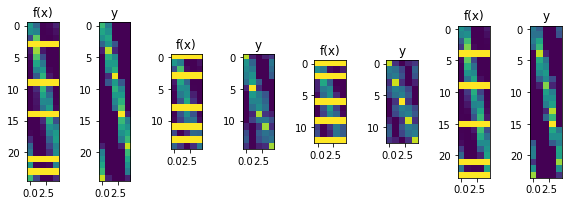

In [80]:
idx = 3

f, axs = plt.subplots(1,BATCHSIZE*2,figsize=(2*BATCHSIZE,5))
i = 0
cutoff = 25
for cutoff,idx in zip(gt_max,range(BATCHSIZE)):
    cutoff = cutoff + 1
    
    axs[i].title.set_text('f(x)')
    temp_pred = pred[idx][:cutoff,:].numpy()
    ind = np.argmax(temp_pred, axis=0)
    print(ind)
    temp_pred[ind,:] = 1
    axs[i].imshow(temp_pred)
    i = i+1
    axs[i].title.set_text('y')
    temp_y = outputs[idx][:cutoff,:]
    print(tf.math.argmax(temp_y, axis=0).numpy())
    axs[i].imshow(temp_y)
    i = i+1
f.tight_layout()

In [42]:
pred[0].shape

TensorShape([36, 5])

In [48]:
print(np.argmax(pred[2][:15,:], axis=0))
print(np.argmax(outputs[2][:15,:], axis=0))

[ 0  2  6  9 12]
[ 0  3  6  9 12]


# Generator tests

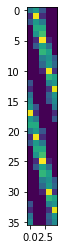

In [20]:
temp = outputs[idx][:]
plt.imshow(temp)

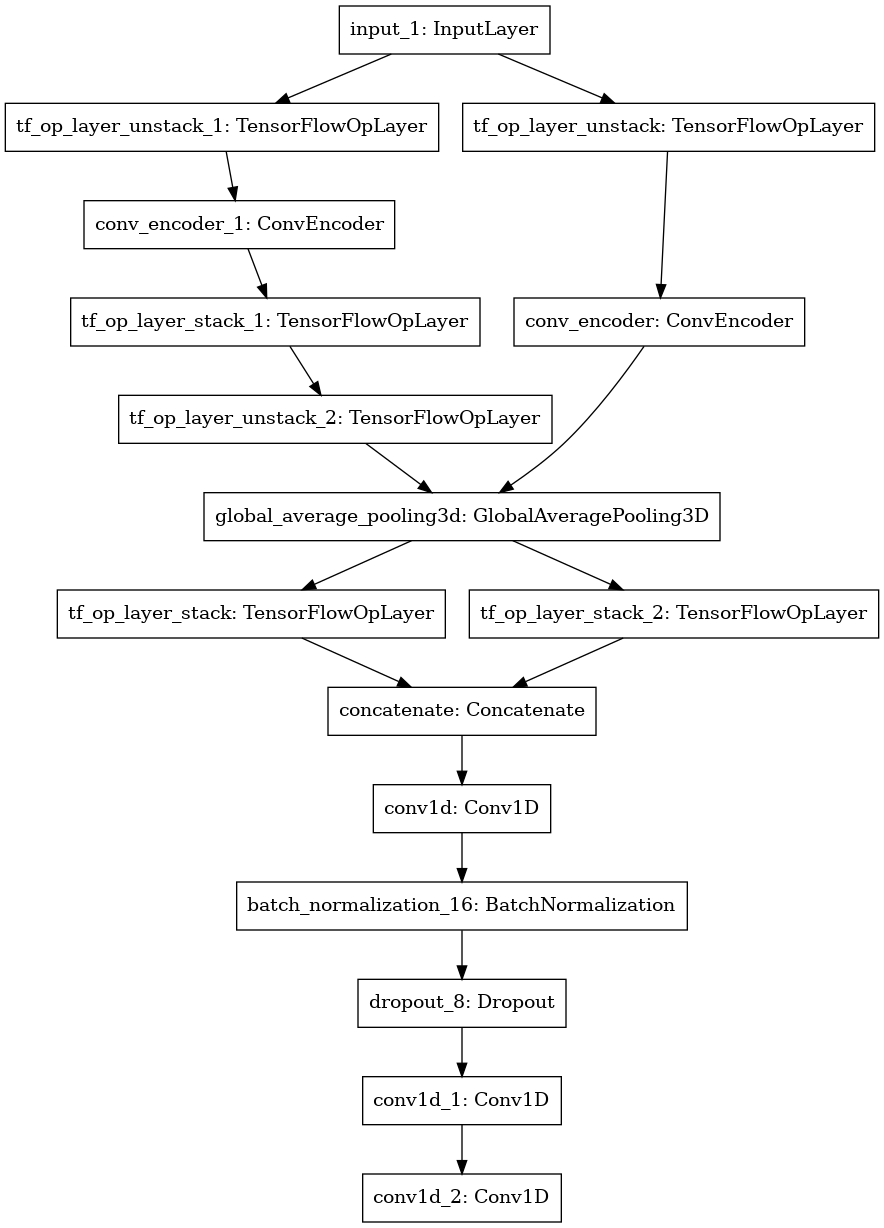

In [16]:
tf.keras.utils.plot_model(
    model, show_shapes=False,
    show_layer_names=True, rankdir='TB', expand_nested=True, dpi=96
)

In [25]:
temp = outputs[1][:]
print(temp.shape)
print(temp)
print(temp.sum(axis=0))
print(temp.sum(axis=1))


(36, 5)
[[0.44444445 0.2777778  0.         0.         0.2777778 ]
 [0.4117647  0.3529412  0.         0.         0.23529412]
 [0.46153846 0.53846157 0.         0.         0.        ]
 [0.3846154  0.61538464 0.         0.         0.        ]
 [0.08333334 0.8333333  0.08333334 0.         0.        ]
 [0.         0.61538464 0.3846154  0.         0.        ]
 [0.         0.4117647  0.3529412  0.23529412 0.        ]
 [0.         0.33333334 0.3888889  0.2777778  0.        ]
 [0.         0.2631579  0.42105263 0.31578946 0.        ]
 [0.         0.07843138 0.78431374 0.13725491 0.        ]
 [0.         0.         0.5        0.5        0.        ]
 [0.         0.         0.13725491 0.78431374 0.07843138]
 [0.         0.         0.31578946 0.42105263 0.2631579 ]
 [0.         0.         0.2777778  0.3888889  0.33333334]
 [0.1904762  0.         0.1904762  0.2857143  0.33333334]
 [0.2777778  0.         0.         0.2777778  0.44444445]
 [0.12       0.         0.         0.08       0.8       ]
 [0.46

In [22]:
lst = [1,2,3,4,5,6,7,8,9]
first = lst[3:]
first.extend(lst[:3])
first

[4, 5, 6, 7, 8, 9, 1, 2, 3]

In [ ]:
onehot = np.array([[1,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,1,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,1,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,1,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,0,0,0,1]])

In [ ]:
onehot.shape

In [ ]:
onehot_t = onehot.T
onehot_t.shape
onehot_t

In [ ]:
print(np.argmax(onehot, axis=1))
print(np.argmax(onehot_t, axis=0))

In [ ]:
# iterate over the phases j
# linspace from i to i+1 from indices
temp = onehot_t[:,0].astype(float)
i = 0
j = 3 + 1
temp[i:j] = np.linspace(i,j,j-i)
temp

In [ ]:
onehot_t = onehot_t.astype(float)
indices = np.argmax(onehot_t, axis=0)
for i in range(onehot_t.shape[1]) :
    start = indices[i]
    # make it a ring
    second = (i+1)%len(indices)
    end = indices[second]
    onehot_t[start:end,i] = np.linspace(1,0,int(end-start))
onehot_t
             
    

In [ ]:
plt.imshow(temp)

In [ ]:
plt.imshow(temp.T)

In [ ]:
%%timeit
temp.mean()

In [ ]:
%%timeit
np.mean(temp)

In [ ]:
np.linspace(-1,1,10)